Before you begin, execute this cell to import numpy and packages from the D-Wave Ocean suite, and all necessary functions for the gate-model framework you are going to use, whether that is the Forest SDK or Qiskit. In the case of Forest SDK, it also starts the qvm and quilc servers.

In [2]:
# %run -i "assignment_helper.py"
from helper import *
%matplotlib inline

# Mapping clustering to discrete optimization

We will have $\{x_i\}_{i=1}^N$ points lying in two distant regions:

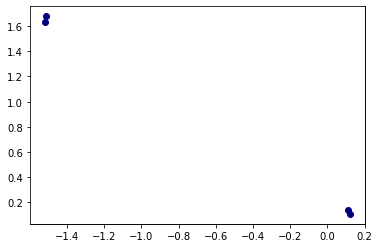

In [6]:
import matplotlib.pyplot as plt
np.set_printoptions(precision=3, suppress=True)
np.random.seed(0)

# Generating the data
c1 = np.random.rand(2, 2)/5
c2 = (-1.6, 1.5) + np.random.rand(2, 2)/5
data = np.concatenate((c1, c2))
plt.subplot(111, xticks=[], yticks=[])
plt.axes()
plt.scatter(data[:, 0], data[:, 1], color='navy')


**Exercise 1** (3 points). The unsupervised task is identify this structure. The challenge is that if we have a high number of points compared to the number of qubits and their connections, we won't be able to solve the problem. So if we blindly follow the idea of mapping the problem to max-cut using the Eucledian distance and then solve it by some quantum optimization method, we would run out of qubit connections for this problem. We can, however, choose to be clever about how we calculate the distances classically. This is a common trick: since we are doing hybrid classical-quantum algorithms anyway, we might as well do the classical parts wisely.

In this case, we might rely on some form of [exploratory data analysis](https://en.wikipedia.org/wiki/Exploratory_data_analysis) to get a sense of the distances in the dataset. This is an easy case, since we just plotted the two-dimensional data, and we see that the density within a blob is high. You can make the task easier by thresholding the distances. Use any distance function you wish (even the Euclidean distance will do) and set distances to zero that are below a threshold you calculate. The threshold should be such that all of the distances within a blob will be set to zero. Store the symmetrix distance matrix in a two-dimensional numpy array called `w`.

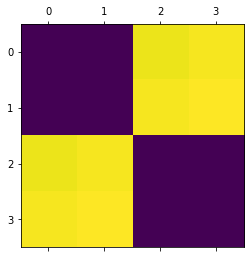

In [7]:
import itertools

n_instances = data.shape[0]

w = np.zeros((n_instances, n_instances))

for i, j in itertools.product(*[range(n_instances)]*2):
    w[i, j] = np.linalg.norm(data[i]-data[j])
    # print(i,j)
w[ w < 0.3] = 0
plt.matshow(w)

In [8]:
labels = np.array([0, 0, 1, 1])
assert np.alltrue(w == w.T)
assert np.alltrue(w >= 0)
assert (w[labels==0][:, labels==0]==0).sum() == 4
assert (w[labels==1][:, labels==1]==0).sum() == 4

# Solving the max-cut problem by QAOA

**Exercise 2** (2 points). From here, it is rather formulaic to create the max-cut as an Ising Hamiltonian and solve either by annealing or by some variational circuit like QAOA. Set up the QAOA problem in your chosen framework and an optimization function. Import all necessary functions you need. Call the object `qaoa`. We set the `p` parameter of the QAOA to 1.

In [32]:
import qiskit_algorithms
from qiskit_algorithms.minimum_eigensolvers import QAOA
from qiskit_algorithms.optimizers import COBYLA
from qiskit_optimization.applications import Maxcut

from qiskit_aer.primitives import Sampler as AerSampler

from qiskit_algorithms.minimum_eigensolvers import  NumPyMinimumEigensolver

In [11]:
max_cut = Maxcut(w)
qp  = max_cut.to_quadratic_program()
qubitOp, offset = qp.to_ising()
qp.prettyprint()

'Problem name: Max-cut\n\nMaximize\n  -4.404244807134012*x_0*x_2 - 4.467158887112036*x_0*x_3\n  - 4.4662858711734605*x_1*x_2 - 4.529790840466258*x_1*x_3\n  + 4.435701847123024*x_0 + 4.498038355819859*x_1 + 4.435265339153736*x_2\n  + 4.498474863789147*x_3\n\nSubject to\n  No constraints\n\n  Binary variables (4)\n    x_0 x_1 x_2 x_3\n'

In [12]:
p = 1

In [46]:

qaoa = QAOA(AerSampler(), COBYLA(), reps=p)
result1  = qaoa.compute_minimum_eigenvalue(qubitOp)

x = max_cut.sample_most_likely(result1.eigenstate)
print('energy:', result1.eigenvalue)
print('maxcut objective:', result1.eigenvalue + offset)
print('solution:', x)
print('solution objective:', qp.objective.evaluate(x))

energy: -2.147265609817515
maxcut objective: -6.614135711288958
solution: [0 0 1 1]
solution objective: 0.0


In [47]:
ee = NumPyMinimumEigensolver()
result2 = ee.compute_minimum_eigenvalue(qubitOp)

x = max_cut.sample_most_likely(result2.eigenstate)
print("energy:", result2.eigenvalue.real)
print("max-cut objective:", result2.eigenvalue.real + offset)
print("solution:", x)
print("solution objective:", qp.objective.evaluate(x))

energy: -4.466870101471442
max-cut objective: -8.933740202942884
solution: [1. 1. 0. 0.]
solution objective: 0.0


Setting $p=1$ in the QAOA algorithm, we can initialize it with the max-cut problem.

In [18]:
qaoa.ansatz.draw()

┌───┐┌─────────────────────────────────────────────────┐»
   q_0: ┤ H ├┤0                                                ├»
        ├───┤│                                                 │»
   q_1: ┤ H ├┤1                                                ├»
        ├───┤│  exp(-it (IZIZ + IZZI + ZIIZ + ZIZI))(1.0*γ[0]) │»
   q_2: ┤ H ├┤2                                                ├»
        ├───┤│                                                 │»
   q_3: ┤ H ├┤3                                                ├»
        └───┘└─────────────────────────────────────────────────┘»
meas: 4/════════════════════════════════════════════════════════»
                                                                »
«        ┌─────────────────────────────────────────────┐ ░ ┌─┐         
«   q_0: ┤0                                            ├─░─┤M├─────────
«        │                                             │ ░ └╥┘┌─┐      
«   q_1: ┤1                                            ├─░──╫─┤M├──────
«        │  exp(-it (XIII + IXII + IIXI + IIIX))(β[0]) │ ░  ║ └╥┘┌─┐   
«   q_2: ┤2                                            ├─░──╫──╫─┤M├───
«        │                                             │ ░  ║  ║ └╥┘┌─┐
«   q_3: ┤3                                            ├─░──╫──╫──╫─┤M├
«        └─────────────────────────────────────────────┘ ░  ║  ║  ║ └╥┘
«meas: 4/═══════════════════════════════════════════════════╩══╩══╩══╩═
«                                                           0  1  2  3

In [43]:
if isinstance(qaoa, qiskit_algorithms.minimum_eigensolvers.qaoa.QAOA):
    assert len(qaoa.ansatz.qubits) == 4
else:
    raise ValueError("Unknown type for Hamiltonian!")

**Exercise 3** (2 points). Run the QAOA on a simulator. Store the outcome in an object called `result`. In the case of the Forest SDK, this will store the return value of the `run_and_measure` method of the QVM. In the case of Qiskit, it will be the return value of the `run` method of the `qaoa` object. ( !! deprecated now)

In [49]:
# we have now two results, Numpy solver seems better
print(result1, result2)

{   'aux_operators_evaluated': None,
    'best_measurement': {   'bitstring': '0011',
                            'probability': 0.3017578125,
                            'state': 3,
                            'value': (-4.466870101471441+0j)},
    'cost_function_evals': 32,
    'eigenstate': {   0: 0.0283203125,
                      1: 0.015625,
                      2: 0.01953125,
                      3: 0.2529296875,
                      4: 0.0068359375,
                      5: 0.0673828125,
                      6: 0.07421875,
                      7: 0.017578125,
                      8: 0.025390625,
                      9: 0.078125,
                      10: 0.0703125,
                      11: 0.0146484375,
                      12: 0.2763671875,
                      13: 0.01953125,
                      14: 0.0107421875,
                      15: 0.0224609375},
    'eigenvalue': -2.147265609817515,
    'optimal_circuit': <qiskit.circuit.quantumcircuit.QuantumCircuit obje

In [50]:
result = result2

In [67]:
def sample_to_list(samp: dict):
    return [samp[i] for i in range(1,len(samp)+1)]

In [77]:
ground_truth1 = [0, 0, 1, 1]
ground_truth2 = [1, 1, 0, 0]
if isinstance(result, list):
    count = np.unique(result, return_counts=True, axis=0)
    solution = count[0][np.argmax(count[1])]
    assert abs(sum(solution == ground_truth1)-4) <= 1 or abs(sum(solution == ground_truth2)-4) <= 1
else:
    x = max_cut.sample_most_likely(result.eigenstate)
    solution = sample_to_list(max_cut.get_gset_result(x))
    # print(solution)
    assert abs(sum(np.array(solution) == np.array(ground_truth1))-4) <= 1 or abs(sum(np.array(solution) == np.array(ground_truth2))-4) <= 1